In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import decomposition
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.mixture import GaussianMixture
from scipy.interpolate import make_interp_spline, BSpline



In [37]:
sales = pd.read_csv('sales_train_v2.csv')
shops = pd.read_csv('shops.csv')
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')

In [38]:
#Merge Columns
merged_1 = items.merge(right = item_categories, how = 'inner', right_on = 'item_category_id',
                       left_on = 'item_category_id', copy = False)
sales = sales.merge(right = merged_1 , how = 'inner' , right_on = 'item_id' , left_on = 'item_id' , copy = False)
sales = sales.merge(right = shops , how = 'inner' , right_on = 'shop_id' , left_on = 'shop_id' , copy = False)
sales.head(10)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,16.05.2013,4,59,2573,249.0,1.0,DEL REY LANA Born To Die,55,Музыка - CD локального производства,"Ярославль ТЦ ""Альтаир"""
2,26.01.2013,0,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,"Ярославль ТЦ ""Альтаир"""
3,09.01.2013,0,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,"Ярославль ТЦ ""Альтаир"""
4,24.02.2013,1,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,"Ярославль ТЦ ""Альтаир"""
5,29.03.2013,2,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,"Ярославль ТЦ ""Альтаир"""
6,19.07.2013,6,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,"Ярославль ТЦ ""Альтаир"""
7,03.07.2013,6,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,"Ярославль ТЦ ""Альтаир"""
8,06.07.2013,6,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,"Ярославль ТЦ ""Альтаир"""
9,28.08.2013,7,59,2574,399.0,1.0,DEL REY LANA Born To Die The Paradise Editio...,55,Музыка - CD локального производства,"Ярославль ТЦ ""Альтаир"""


In [39]:
#Remove ids keep names
column_names = ['date', 'date_block_num', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_name',
       'shop_name']
sales = sales[column_names]

In [49]:
#Data Exploration
sales.groupby(['item_name', 'item_category_name',
       'shop_name']).size().reset_index(name='counts').sort_values(by = 'counts', ascending = False)
sales.groupby(['item_name']).size().reset_index(name='counts').sort_values(by = 'counts', ascending = False)
sales.groupby(['item_category_name']).size().reset_index(name='counts').sort_values(by = 'counts', ascending = False)
sales.groupby(['shop_name']).size().reset_index(name='counts').sort_values(by = 'counts', ascending = False)
#There are 21807 items, 84 item categories and 60 shops

,shop_name,counts
31,"Москва ТЦ ""Семеновский""",235636
25,"Москва ТРК ""Атриум""",186104
54,"Химки ТЦ ""Мега""",143480
28,"Москва ТЦ ""МЕГА Теплый Стан"" II",142234
57,"Якутск Орджоникидзе, 56",117428
42,"СПб ТК ""Невский Центр""",109253
27,"Москва ТЦ ""МЕГА Белая Дача II""",105366
6,"Воронеж (Плехановская, 13)",82663
58,"Якутск ТЦ ""Центральный""",71441
56,"Чехов ТРЦ ""Карнавал""",69573


In [42]:
(sales.date.max(),sales.date.min())
#We have one year data, Time Series Problem

('31.12.2014', '01.01.2013')

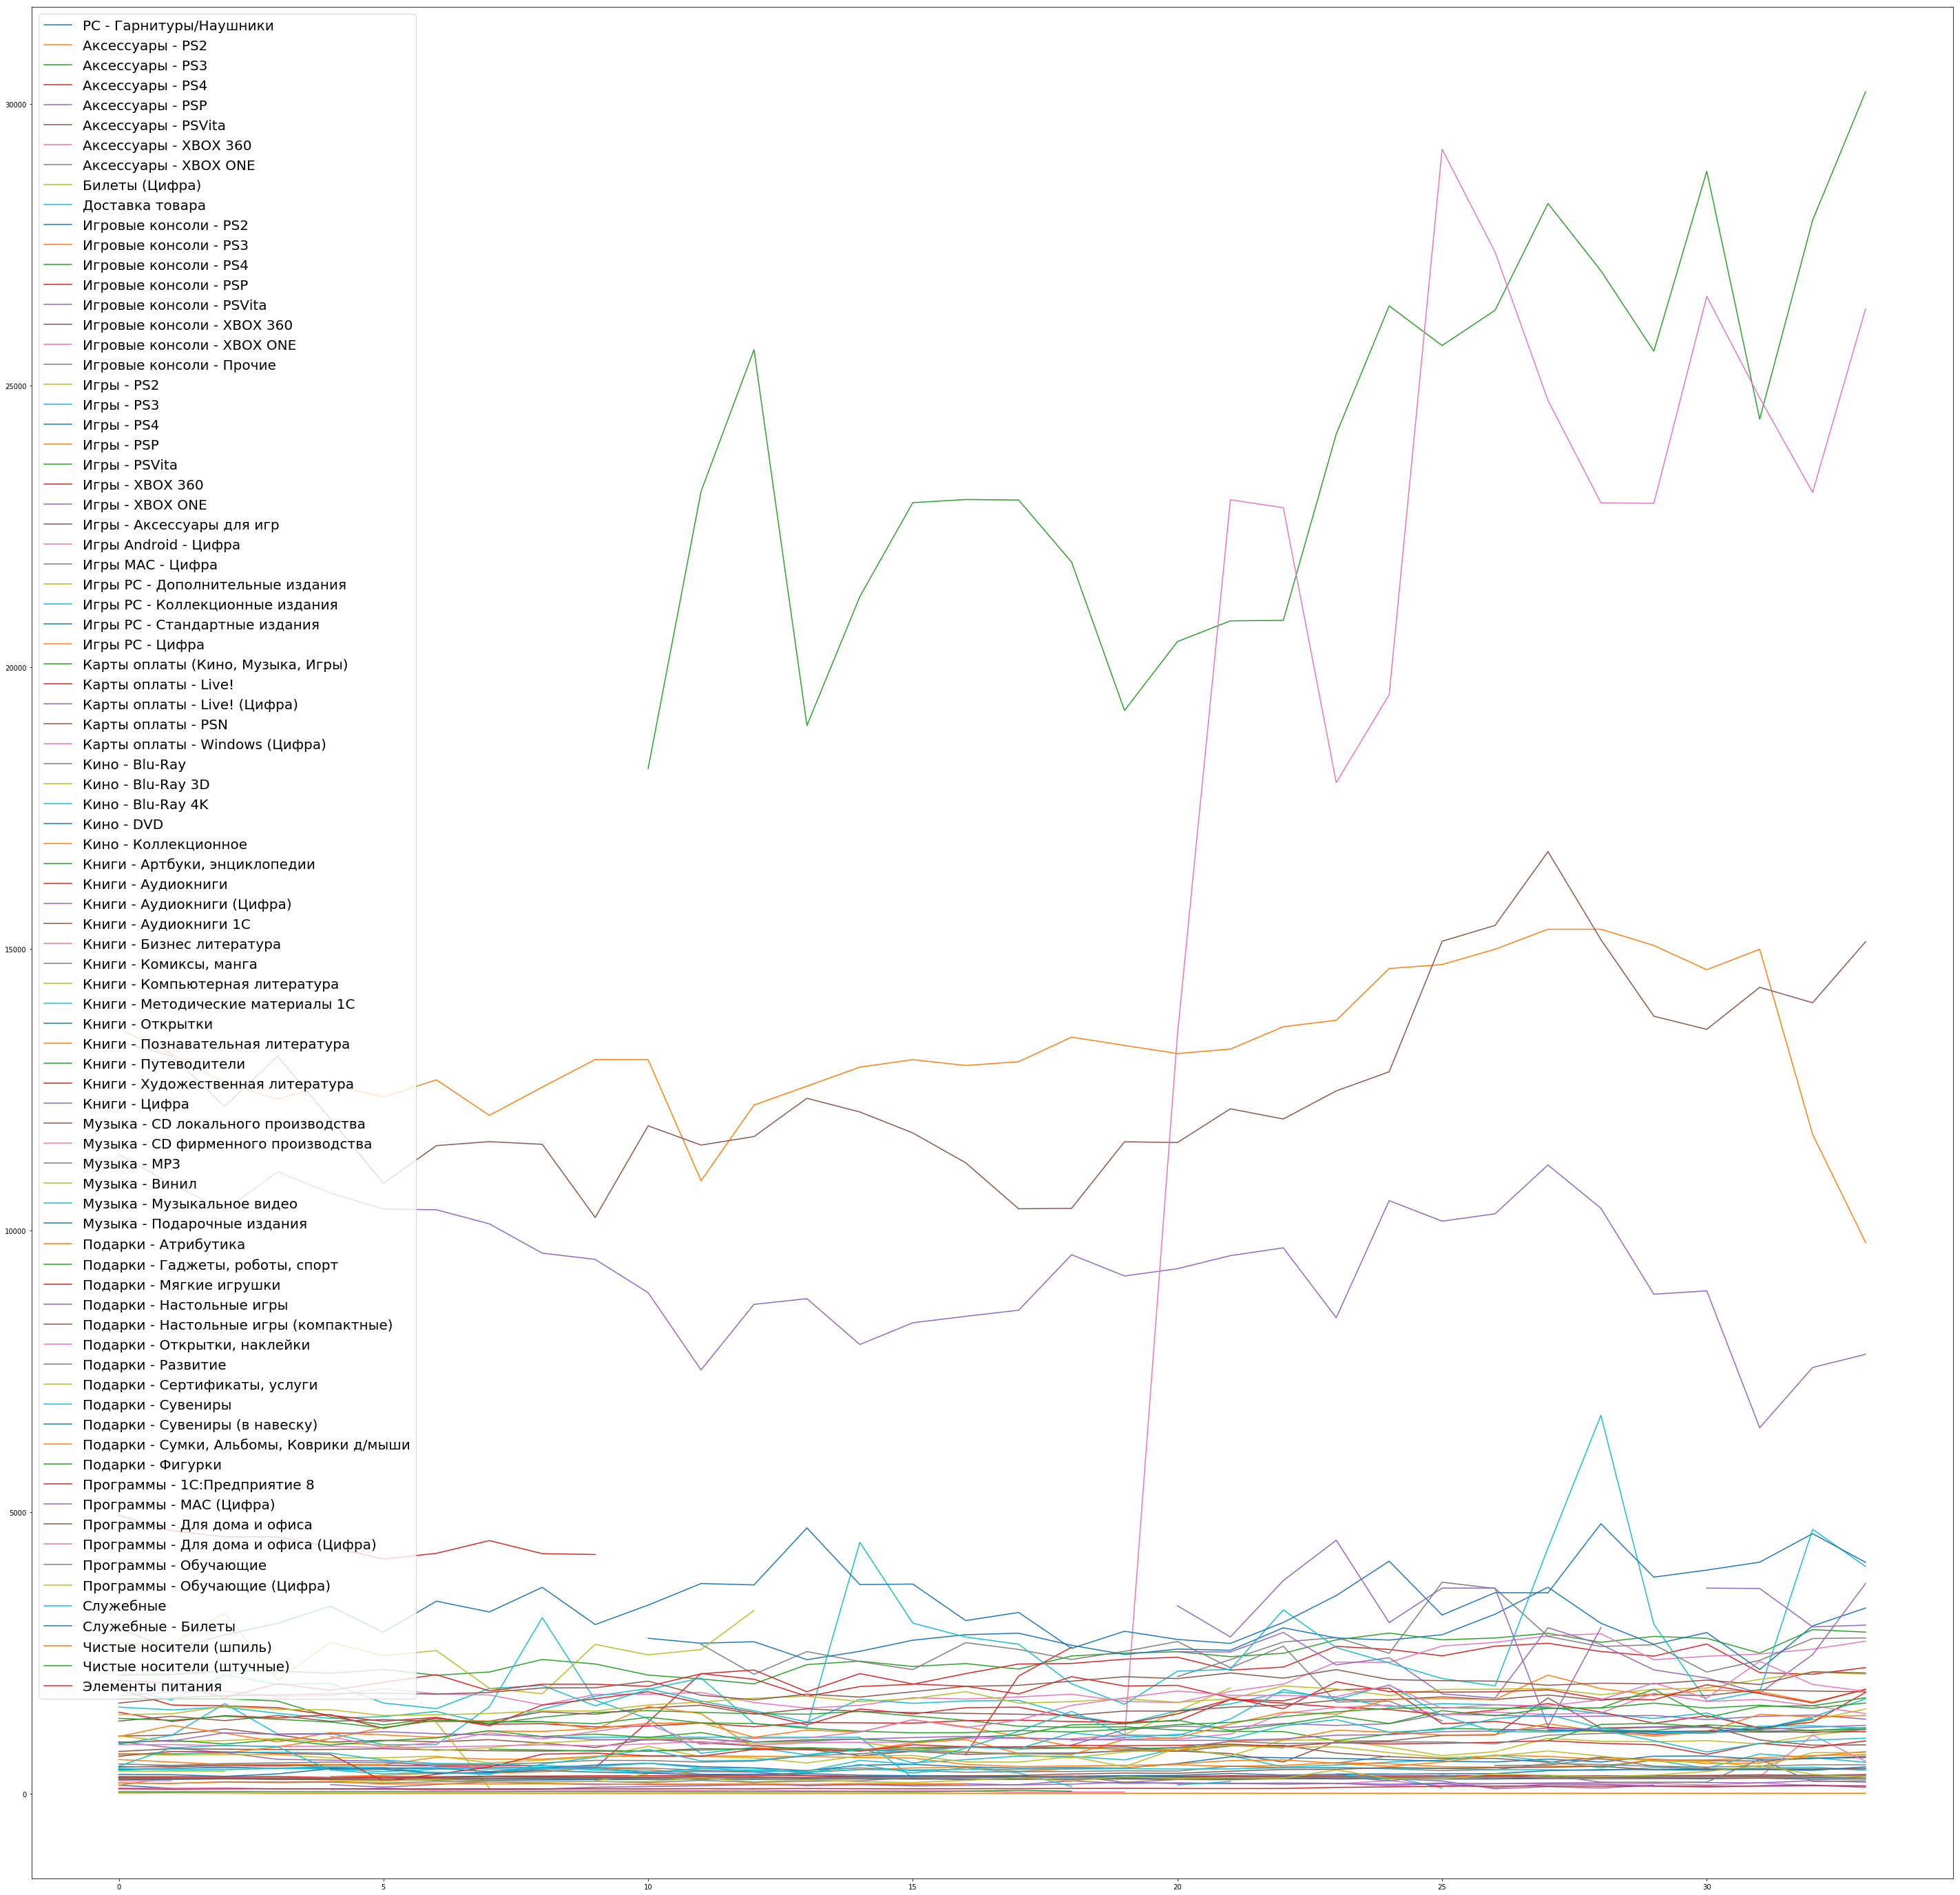

In [142]:
pivot_sales = pd.pivot_table(sales, values='item_price', index=['date_block_num'],
                    columns=['item_category_name'], aggfunc=np.mean)
colnames = pivot_sales.columns 
plt.plot(pivot_sales)
fig_size = plt.rcParams["figure.figsize"]
# Set figure width to 12 and height to 9
fig_size[0] = 50
fig_size[1] = 50
plt.rcParams["figure.figsize"] = fig_size
plt.legend(colnames,loc=2, prop={'size': 20})
plt.show()